In this notebook we try to perform Person Identification (PI) and Human Activity Recognition (HAR) through a self-supervised and supervised contrastive approach, with **ResNet18** or **Inception-v4** as encoder. \
In the following cells you can find all the steps which will train and test the architecture chosen

### Step 0
#### Import of file and packages necessary

First of all, let's import everything is necessary for our purposes. In addition the the various packages, we import even the models under test. In particular, we considered ResNet18, Inception-v4, Inception-v4 Rescaled \
and Inception-v4 Reduced as described in the report. Three out of the four are here commented since we can consider only one case at a time. To train and test other models, it's enough to uncomment the case of interest.

In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader#, #Dataset, 

#from copy import deepcopy
from sklearn.metrics import confusion_matrix
from utils_preprocess import *
from utils_traintest import *
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU, MaxPool2d, AvgPool2d, Linear, Dropout, ZeroPad2d, CrossEntropyLoss
from torch.optim import SGD, Adam, AdamW, lr_scheduler
#import torchvision
from tqdm import tqdm

# import the models
#from models.ResNet18 import ResNet18
from models.Inceptionv4tagliato import Inceptionv4

In [2]:
# Set seeds for reproducibility
# fix this
seed = 203345656
torch.manual_seed(seed)

In [3]:
read_path = "./models/ResNet18"
create_subfolders_from_ckpt(read_path)

Subfolder already exists: ./models/ResNet18\My_ResNet18_hd128_bs128_200ep
Subfolder already exists: ./models/ResNet18\My_ResNet18_hd128_bs256_200ep
Subfolder already exists: ./models/ResNet18\My_ResNet18_hd16_bs128
Subfolder already exists: ./models/ResNet18\My_ResNet18_hd16_bs256_200ep
Subfolder already exists: ./models/ResNet18\My_ResNet18_hd16_bs512
Subfolder already exists: ./models/ResNet18\My_ResNet18_hd256_bs128_200ep
Subfolder already exists: ./models/ResNet18\My_ResNet18_hd256_bs256_200ep
Subfolder already exists: ./models/ResNet18\My_ResNet18_hd32_bs128
Subfolder already exists: ./models/ResNet18\My_ResNet18_hd32_bs256_200ep
Subfolder already exists: ./models/ResNet18\My_ResNet18_hd32_bs512_200ep
Subfolder already exists: ./models/ResNet18\My_ResNet18_hd64_bs128
Subfolder already exists: ./models/ResNet18\My_ResNet18_hd64_bs256_200ep
Subfolder already exists: ./models/ResNet18\My_ResNet18_hd64_bs512_200ep
Subfolder already exists: ./models/ResNet18\SimCLR_ResNet18_self
Subfol

Now we define the activities considered, known from the dataset at our disposal. In this case we're considering 7 activities, as described in the report, while for the 5 activities case the last two should be omitted.

In [3]:
activities_considered = 'E,L,W,R,J,H,S'

### Step 1
#### Class definition and training for encoder 
**This can be either done with self-supervised contrastive, or with supervised contrastive** \
In the following cell we're considering Inceptionv4 model 

In [2]:
# IT IS MANDATORY to modify the classification_layer of the ResNet18 (if there is any, after the network)
# otherwise when we call self.encoder(x) we will call the "old" one in the ResNet class
# (for comparison see the colab example)

class SimCLR18(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        # Base model f(.)
        self.encoder = Inceptionv4(hidden_dim)

        # projection head g(.): modify the ResNet18 attribute
        # so that we dont need to modify the ResNet18 forward method
        self.encoder.classification_layer = nn.Sequential(
            #nn.Dropout(0.2),
            nn.Linear(2560, 4*hidden_dim),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.2),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def forward(self, x):
        feats = self.encoder(x)
        return feats

##### 1.1 Self-supervised contrastive learning
In this case we're considering the first approach. The first commands describe the path to the traces used as inputs, and with "transforms" we're defining the transformation used for DataAugmentation.\
The last three lines are used to create our dataset for training and validation (and test, even if in our case we're not using this, since all the tests are done just considering the projection head only). \
For what concerns `dataset_csi_self_train`, here we're defining also the batch_size, since it's been one of the hyperparameters considered in the training of our model. Another thing that one could in principle change is the activitiies considered (see `create_training_set` function defined in `utils_preprocess.py` file), but since at the first stages we have considered just 5 activities, here it's non been included between the input specified.

In [ ]:
dir_init = './doppler_traces/' 
subdirs_init = 'S1a,S1b,S1c' 
transforms = DopplerTransformations()

dataset_csi_self_train = create_training_set(dir_init=dir_init, subdirs_init=subdirs_init, transform=transforms, batch_size_init=128)
dataset_csi_self_val = create_validation_set(dir_init=dir_init, subdirs_init=subdirs_init, transform=transforms)
dataset_csi_self_test, labels_true_test = create_test_set(dir_init=dir_init, subdirs_init=subdirs_init, transform=transforms)

Now we can proceed with the training. In the following cell we're defining all the parameters necessary. 

In [ ]:
# Define training hyperparameters
hidden_dim=128
temperature=0.07
weight_decay=1e-4
max_epochs=500
lr=2e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 100

#path to the folder where pretrained models are saved
CHECKPOINT_PATH = "./saved_models"


# Define SimCLR Model
simclr_model = SimCLR18(hidden_dim)

# Define Optimizer and Learning rate Scheduler
optimizer = AdamW(simclr_model.parameters(), lr=lr, weight_decay=weight_decay)
my_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max = max_epochs, eta_min=lr/50)

# Training Loop
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val = 100

for epoch in range(epochs):
    # Training iterations and update lists
    train_loss, train_top1_acc = train_contrastive_self(simclr_model, device, dataset_csi_self_train, optimizer, my_lr_scheduler, epoch, loss_temperature=temperature)
    train_losses.append(train_loss)
    train_accs.append(train_top1_acc)

    # Validation iterations
    val_loss, val_top1_acc = valid_constrastive_self(simclr_model, device, dataset_csi_self_val, epoch, loss_temperature=temperature)
    val_losses.append(val_loss)
    val_accs.append(val_top1_acc)

    if val_losses[-1] < best_val:
            iteration = epoch
            # Save the model, the name should be changed accordingly to the model considered
            torch.save(simclr_model.state_dict(), os.path.join(CHECKPOINT_PATH, 'SimCLR_Inceptionv4_self.ckpt'))
            # saves the curves
            csv_file_path = os.path.join(CHECKPOINT_PATH, 'training_metrics_self.csv')
            print("Saved Model")
            best_val = val_losses[-1]
            # Write the lists to a CSV file
            with open(csv_file_path, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['Epoch', 'Train Loss', 'Validation Loss', 'Train Top-5 Accuracy', 'Validation Top-5 Accuracy'])
                writer.writerow([epoch + 1, train_losses[epoch], val_losses[epoch], train_accs[epoch], val_accs[epoch]])
            print(f"Training metrics saved to {csv_file_path}")

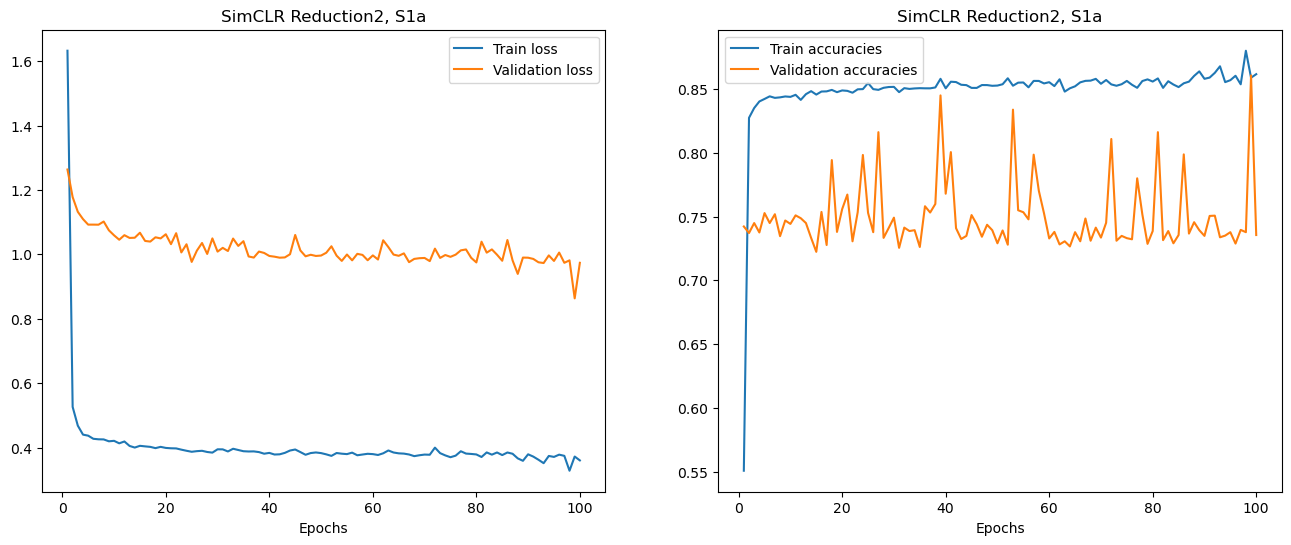

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(np.arange(1, 101), train_losses, label="Train loss")
ax1.plot(np.arange(1, 101), val_losses, label="Validation loss")
ax1.set_xlabel("Epochs")
ax1.set_title("SimCLR Inceptionv4, S1")
ax1.legend()
ax2.plot(np.arange(1,101), train_accs, label="Train accuracy")
ax2.plot(np.arange(1,101), val_accs, label="Validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_title("SimCLR Inceptionv4, S1")
ax2.legend()

##### 1.2 Supervised contrastive learning 
In this case we're considering the same steps but with the supervised contrastive approach. In this case we're always considering data transformation, without increasing the number of inputs.

In [7]:
dir_init = './doppler_traces/' 
subdirs_init = 'S1a,S1b,S1c' 
transforms = DopplerTransformations(n_views=1)

dataset_csi_sup_train = create_training_set(dir_init=dir_init, subdirs_init=subdirs_init, aggregate=True, transform=transforms, batch_size_init=256)
dataset_csi_sup_val = create_validation_set(dir_init=dir_init, subdirs_init=subdirs_init, aggregate=True, transform=transforms, batch_size_init=256)
dataset_csi_sup_test, labels_true_test = create_test_set(dir_init=dir_init, subdirs_init=subdirs_init, aggregate=True)

In [ ]:
# Define training hyperparameters
hidden_dim=32
temperature=0.07
weight_decay=1e-4
max_epochs=500
lr=2e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 100

#path to the folder where pretrained models are saved
CHECKPOINT_PATH = "./models"

# Define SimCLR Model
simclr_model = SimCLR18(hidden_dim)

# Define Optimizer and Learning rate Scheduler
optimizer = AdamW(simclr_model.parameters(), lr=lr, weight_decay=weight_decay)
my_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max = max_epochs, eta_min=lr/50)

# Training Loop
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val = 100

for epoch in range(epochs):
    # Training iterations and update lists
    train_loss, train_top1_acc = train_contrastive_sup(simclr_model, device, dataset_csi_sup_train, optimizer, my_lr_scheduler, epoch, loss_temperature=temperature)
    train_losses.append(train_loss)
    train_accs.append(train_top1_acc)

    # Validation iterations
    val_loss, val_top1_acc = valid_contrastive_sup(simclr_model, device, dataset_csi_sup_val, epoch, loss_temperature=temperature)
    val_losses.append(val_loss)
    val_accs.append(val_top1_acc)

    if val_losses[-1] < best_val:
            iteration = epoch
            # Save the model
            torch.save(simclr_model.state_dict(), os.path.join(CHECKPOINT_PATH, 'SimCLR_ResNet18_sup.ckpt'))
            # saves the curves
            csv_file_path = os.path.join(CHECKPOINT_PATH, 'training_metrics_sup.csv')
            print("Saved Model")
            best_val = val_losses[-1]
            # Write the lists to a CSV file
            with open(csv_file_path, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['Epoch', 'Train Loss', 'Validation Loss', 'Train Top-5 Accuracy', 'Validation Top-5 Accuracy'])
                writer.writerow([epoch + 1, train_losses[epoch], val_losses[epoch], train_accs[epoch], val_accs[epoch]])
            print(f"Training metrics saved to {csv_file_path}")

Train Epoch: 0,  	Loss: 5.099028, 	Top1_Acc: 0.002817
Valid Epoch: 0,  	Loss: 5.028608, 	Top1_Acc: 0.006048
Saved Model
Training metrics saved to ./models\training_metrics_sup.csv
Train Epoch: 1,  	Loss: 3.711144, 	Top1_Acc: 0.051463
Valid Epoch: 1,  	Loss: 5.004951, 	Top1_Acc: 0.041506
Saved Model
Training metrics saved to ./models\training_metrics_sup.csv
Train Epoch: 2,  	Loss: 2.659125, 	Top1_Acc: 0.275587
Valid Epoch: 2,  	Loss: 3.979054, 	Top1_Acc: 0.248409
Saved Model
Training metrics saved to ./models\training_metrics_sup.csv
Train Epoch: 3,  	Loss: 1.953763, 	Top1_Acc: 0.589605
Valid Epoch: 3,  	Loss: 3.720153, 	Top1_Acc: 0.334503
Saved Model
Training metrics saved to ./models\training_metrics_sup.csv
Train Epoch: 4,  	Loss: 1.824861, 	Top1_Acc: 0.662946
Valid Epoch: 4,  	Loss: 3.942482, 	Top1_Acc: 0.293121
Train Epoch: 5,  	Loss: 1.742156, 	Top1_Acc: 0.700310
Valid Epoch: 5,  	Loss: 4.070505, 	Top1_Acc: 0.327599
Train Epoch: 6,  	Loss: 1.730323, 	Top1_Acc: 0.705263
Valid Epoc

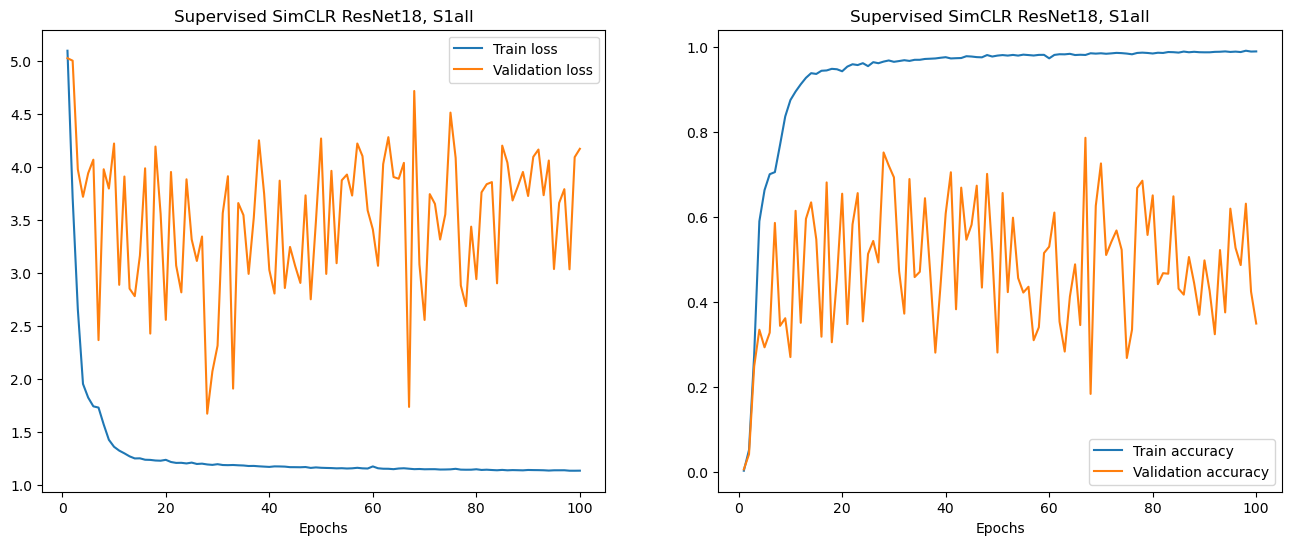

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(np.arange(1, 101), train_losses, label="Train loss")
ax1.plot(np.arange(1, 101), val_losses, label="Validation loss")
ax1.set_xlabel("Epochs")
ax1.set_title("Supervised SimCLR ResNet18, S1all")
ax1.legend()
ax2.plot(np.arange(1,101), train_accs, label="Train accuracy")
ax2.plot(np.arange(1,101), val_accs, label="Validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_title("Supervised SimCLR ResNet18, S1all")
ax2.legend()

### Step 2

#### 2.1.1 
#### Train & Test of the classifier for HAR
Now we proceed removing the classification layer from the encoder model and appending a projection head for HAR classification tasks.\
We test different classifiers with either one, two or three layers.

In [ ]:
class SimpleClassifierOneLayer(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.name = 'SimpleClassifierOneLayer'

        # Mapping from representation h to classes with a linear layer
        self.model = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.model(x)
    
class SimpleClassifierThreeLayers(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.name = 'SimpleClassifierThreeLayers'

        # Mapping from representation h to classes with a linear layer
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 68),
            nn.ReLU(inplace=True),
            nn.Dropout(0.38695150209717766),
            nn.Linear(68, 173),
            nn.ReLU(inplace=True),
            nn.Dropout(0.05106801720058318),
            nn.Linear(173, num_classes),

        )

    def forward(self, x):
        return self.model(x)
    
class SimpleClassifierTwoLayers(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.name = 'SimpleClassifierTwoLayers'

        # Mapping from representation h to classes with a linear layer
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 130),
            nn.ELU(inplace=True),
            nn.Linear(130, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In case we want to study the performances of an encoder previously trained, we can run the following cell to load the model yet trained.

In [164]:
# Save the encoder
#torch.save(simclr_model.state_dict(), os.path.join(CHECKPOINT_PATH, 'My_SimCLR.ckpt'))
simclr_model = SimCLR18(hidden_dim=32)

# Load the trained encoder here
path_model = 'models/SimCLR_ResNet18_sup.ckpt'
simclr_model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu'), weights_only=True))
save_dir = 'models/SimCLR_ResNet18_sup'

Now we proceed preparing the dataset for training and validation. In this case, we specify the activities considered, since we can be in the case in which we want
to study 5 or 7 activities (for the former case we can even neglect the input `activities_init`). \
After doing that, we prepare the data passing through the encoder because our projection head work with the feature vector obtained after the encoder stage.


In [ ]:
# encode the input data (train, test & validation) with the trained representation
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a,S1b,S1c' #Subdirs for training

dataset_csi_train_class = create_training_set(dir_init=dir_init, subdirs_init=subdirs_init, activities_init=activities_considered)
dataset_csi_val_class = create_validation_set(dir_init=dir_init, subdirs_init=subdirs_init, activities_init=activities_considered)

train_feats = prepare_data_features(simclr_model, dataset_csi_train_class, device=device, supervised=True)
val_feats = prepare_data_features(simclr_model, dataset_csi_val_class, device=device, supervised=True)

100%|██████████| 296/296 [00:09<00:00, 32.08it/s]


Then we are ready to effectively train our projection head. As for the encoder, we consider only the S1 set for this part.

In [ ]:
dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a,S1b,S1c' #Subdirs for training
batch_size=64
num_classes=7
lr=1e-3
weight_decay=1e-3
epochs=100
har_projection_head = SimpleClassifierOneLayer(2560, num_classes=7)
opt = AdamW(har_projection_head.parameters(), lr=lr, weight_decay=weight_decay)
save_name_proj = har_projection_head.name+'_HAR'+'_'+activities_considered

train_losses, train_accs, val_losses, val_accs = train_projection(model=har_projection_head, optimizer=opt, train_feats_data=train_feats, val_feats_data=val_feats, save_dir=save_dir, save_name=save_name_proj+'.ckpt', device="cuda", batch_size=batch_size, epochs=epochs)

Epoch: 0, Train Loss: 0.251117, Train Accuracy: 0.903164
Epoch: 0, Val Loss: 0.169722, Val Accuracy: 0.944890
Saved Model
Epoch: 1, Train Loss: 0.138148, Train Accuracy: 0.951186
Epoch: 1, Val Loss: 0.141171, Val Accuracy: 0.958509
Saved Model
Epoch: 2, Train Loss: 0.108142, Train Accuracy: 0.963607
Epoch: 2, Val Loss: 0.095961, Val Accuracy: 0.976774
Saved Model
Epoch: 3, Train Loss: 0.091326, Train Accuracy: 0.968383
Epoch: 3, Val Loss: 0.078404, Val Accuracy: 0.976351
Saved Model
Epoch: 4, Train Loss: 0.075799, Train Accuracy: 0.975229
Epoch: 4, Val Loss: 0.067380, Val Accuracy: 0.980680
Saved Model
Epoch: 5, Train Loss: 0.063808, Train Accuracy: 0.981198
Epoch: 5, Val Loss: 0.068083, Val Accuracy: 0.979307
Epoch: 6, Train Loss: 0.061288, Train Accuracy: 0.979691
Epoch: 6, Val Loss: 0.064304, Val Accuracy: 0.988176
Saved Model
Epoch: 7, Train Loss: 0.050245, Train Accuracy: 0.985194
Epoch: 7, Val Loss: 0.069771, Val Accuracy: 0.983953
Epoch: 8, Train Loss: 0.047583, Train Accuracy: 

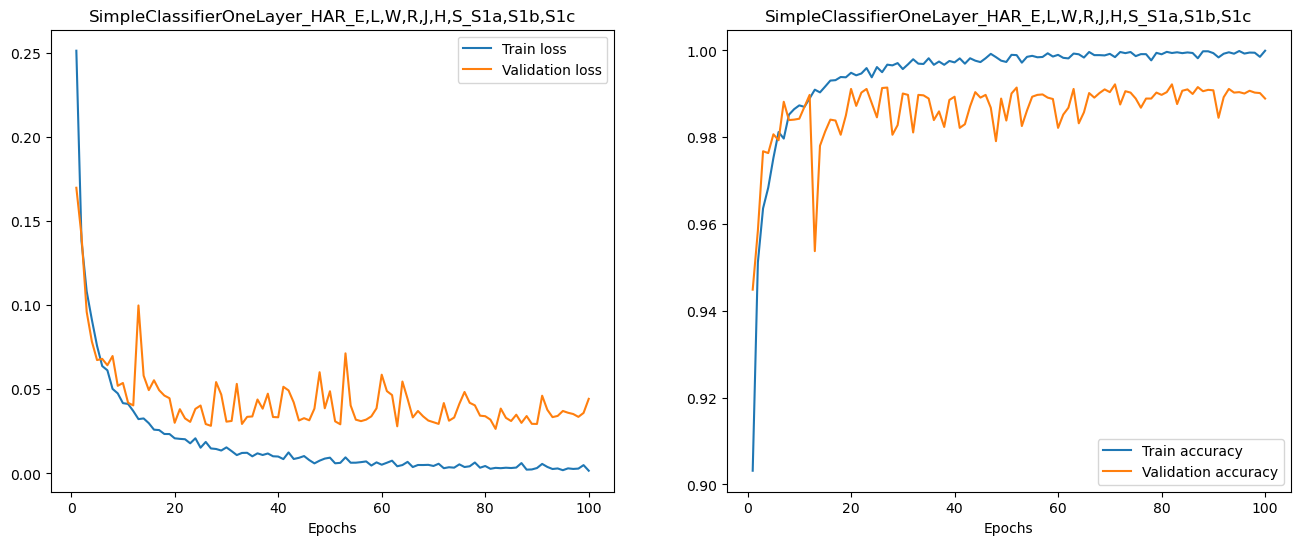

In [178]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(np.arange(1, epochs+1), train_losses, label="Train loss")
ax1.plot(np.arange(1, epochs+1), val_losses, label="Validation loss")
ax1.set_xlabel("Epochs")
#ax1.set_title("SimpleClassifier_HAR_hd16_bs128, S1a")
ax1.set_title(str(save_name_proj)+'_'+str(subdirs_init))
ax1.legend()
ax2.plot(np.arange(1,epochs+1), train_accs, label="Train accuracy")
ax2.plot(np.arange(1,epochs+1), val_accs, label="Validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_title(str(save_name_proj)+'_'+str(subdirs_init))
ax2.legend()

Now that we have our projection head trained, we can proceed testing it. First of all, we consider the test on the same set of the training (so, S1), to see how \
it behaves in the best case scenario. The same comments done before for the functions involved, now are still valid.

In [ ]:
### TEST ###

dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a,S1b,S1c' #Subdirs for training

dataset_csi_test_class, labels_true_test = create_test_set(dir_init=dir_init, subdirs_init=subdirs_init, activities_init=activities_considered)
test_feats = prepare_data_features(simclr_model, dataset_csi_test_class, device=device, supervised=True)

#Inside the arange we have to put as input the number of activities considered
labels_considered = np.arange(7)

100%|██████████| 290/290 [00:08<00:00, 34.39it/s]


Even in this case we load the model from the file where we store our model during the training. This is to avoid the repetition of the same training every time \
we want to study an architecture yet trained with the same parameters.

In [180]:
# define a classifier object
classifier_model = har_projection_head

# Load the trained projection head here
path_model = save_dir+'/'+save_name_proj+'.ckpt'
classifier_model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu'), weights_only=True))

<All keys matched successfully>

And now we proceed testing our projection head. For our classification purposes, we consider the Cross Entropy loss function.

In [181]:
# test the projection head on the test set:
# start from the input test set, extract the feature representation via the encoder

device = 'cuda' if torch.cuda.is_available() else 'cpu'
classifier_model.to(device)
classifier_model.eval()
batch_size = 64
loss_fn = CrossEntropyLoss()

with torch.no_grad():
    predictions = []
    true = []

    test_loader = DataLoader(test_feats, batch_size=batch_size, shuffle=False, drop_last=False)

    for batch in tqdm(test_loader):
        feats, labels = batch
        feats = feats.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(dim=1)
        preds = classifier_model(feats)
        predictions.append(preds)
        true.append(labels)

    predictions = torch.cat(predictions, axis=0) # concatenate the predictions for all batches
    true = torch.cat(true, axis=0)
    print("shape of the predicted labels list:", predictions.shape)
    print("shape of the true labels:", true.shape)
    test_loss = loss_fn(predictions, true)
    true = true.detach().cpu()
    labels_pred_list_test = torch.softmax(predictions, dim=1).detach().cpu()
    labels_pred_test = labels_pred_list_test.argmax(dim=1) # restituisce l'indice del valore maggiore
    test_acc = (labels_pred_test == true).float().mean()
    conf_matrix = confusion_matrix(true, labels_pred_test)
    print(f"loss: {test_loss}, accuracy: {test_acc}")

100%|██████████| 145/145 [00:00<00:00, 1726.01it/s]

shape of the predicted labels list: torch.Size([9268, 7])
shape of the true labels: torch.Size([9268])
loss: 0.02059122920036316, accuracy: 0.9942814111709595


As described in the report, during the test we merge the predictions coming from each antenna through a decision function described also in the definition of \
the function `merge_predictions`. Here we show the confusion matrix that we obtain after using that function.

c:\Users\feder\NNDL-HAR-project\utils_traintest.py:463: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(name_fig)
c:\Users\feder\anaconda3\envs\nnml\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


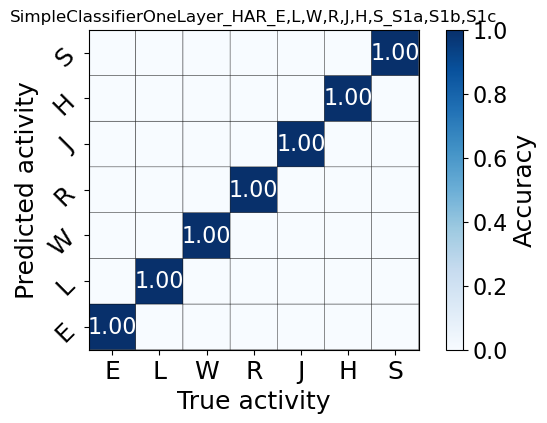

In [ ]:
### Merge the predictions from the various antennas ###
labels_pred_max_merged = merge_predictions(labels_true_test, labels_pred_list_test, labels_pred_test)
conf_matrix_max_merged = confusion_matrix(labels_true_test, labels_pred_max_merged, labels=labels_considered)
#In the following array we put the activities considered
activities = np.array(['E','L','W','R','J','H','S'])
plt_confusion_matrix(activities.shape[0], conf_matrix_max_merged, lables=activities, title=str(save_name_proj)+'_'+str(subdirs_init), save_dir=save_dir, save_name=save_name_proj)

### 2.2
#### Train & Test the 2nd classifier

Now we train the second projection head, used for Person Identification.\
Our dataset has 3 different "people" features. We need to labels data according to the person it refers to, and then to train the projection head on these.\
The dataset are divided as follows: 
- S1, S2, S4, S6 -> P1
- S3, S5 -> P2
- S7 -> P3

***REMEBER TO CHANGE THE NUMBER OF OUTPUT CLASSES!***


In the report, the results reported for what concerns PI are related to the data coming from all the possible activities (because the results were good). \
Nevertheless, in principle, it's possible to consider just one activity (which is the easy way to perform this task), and to do that we should run the following \
cell to redefine `activities_considered`.

In [ ]:
activities_considered = "L"

As for the case of HAR's task, even for PI we load the encoder of our interest, and then apply the function `prepare_data_features` to translate our input in a feature vector, adapting to the kind of input accepted by the projection head.

In [31]:
simclr_model = SimCLR18(hidden_dim=32)
path_model = 'models/SimCLR_ResNet18_sup.ckpt'
save_dir = 'models/SimCLR_ResNet18_sup'
simclr_model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu'), weights_only=True))

<All keys matched successfully>

In this case, for S1 we take only S1a. This is because we noticed that taking also S1b and S1c, the accuracies lowered because the number of inputs associated to the first person becomes too high with respect to P2 and P3. This situation brought our models to predicting always P1, because it learned that this kind of choice is advantageous.

In [34]:
# encode the input data (train, test & validation) with the trained representation
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a,S3a,S7a' #Subdirs for training
n_people = 3

dataset_PI_train_class = create_training_set(dir_init=dir_init, subdirs_init=subdirs_init, activities_init=activities_considered, PI=n_people)
dataset_PI_val_class = create_validation_set(dir_init=dir_init, subdirs_init=subdirs_init, activities_init=activities_considered, PI=n_people)

train_feats_PI = prepare_data_features(simclr_model, dataset_PI_train_class, device=device, supervised=True)
val_feats_PI = prepare_data_features(simclr_model, dataset_PI_val_class, device=device, supervised=True)

100%|██████████| 204/204 [00:06<00:00, 30.03it/s]


In [35]:
dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a,S3a,S7a' #Subdirs for training

batch_size=64
num_classes=n_people
lr=1e-3
weight_decay=1e-3
epochs = 200
pi_projection_head = SimpleClassifierOneLayer(2560, num_classes=n_people) # use the same model as for HAR
opt = AdamW(pi_projection_head.parameters(), lr=lr, weight_decay=weight_decay)
save_name_proj = pi_projection_head.name+'_PI'+'_'+activities_considered

train_losses_PI, train_accs_PI, val_losses_PI, val_accs_PI = train_projection(model=pi_projection_head, optimizer=opt, train_feats_data=train_feats_PI, val_feats_data=val_feats_PI, save_dir=save_dir, save_name=save_name_proj+'.ckpt', device="cpu", batch_size=batch_size, epochs=epochs)

Epoch: 0, Train Loss: 0.698201, Train Accuracy: 0.700819
Epoch: 0, Val Loss: 0.493258, Val Accuracy: 0.835631
Saved Model
Epoch: 1, Train Loss: 0.430057, Train Accuracy: 0.855582
Epoch: 1, Val Loss: 0.398527, Val Accuracy: 0.845895
Saved Model
Epoch: 2, Train Loss: 0.326798, Train Accuracy: 0.906254
Epoch: 2, Val Loss: 0.283546, Val Accuracy: 0.931679
Saved Model
Epoch: 3, Train Loss: 0.268611, Train Accuracy: 0.927101
Epoch: 3, Val Loss: 0.246512, Val Accuracy: 0.939338
Saved Model
Epoch: 4, Train Loss: 0.227624, Train Accuracy: 0.940492
Epoch: 4, Val Loss: 0.232396, Val Accuracy: 0.940104
Saved Model
Epoch: 5, Train Loss: 0.204227, Train Accuracy: 0.945491
Epoch: 5, Val Loss: 0.194318, Val Accuracy: 0.950368
Saved Model
Epoch: 6, Train Loss: 0.175101, Train Accuracy: 0.957279
Epoch: 6, Val Loss: 0.174031, Val Accuracy: 0.963235
Saved Model
Epoch: 7, Train Loss: 0.160828, Train Accuracy: 0.960272
Epoch: 7, Val Loss: 0.174184, Val Accuracy: 0.960784
Epoch: 8, Train Loss: 0.146700, Trai

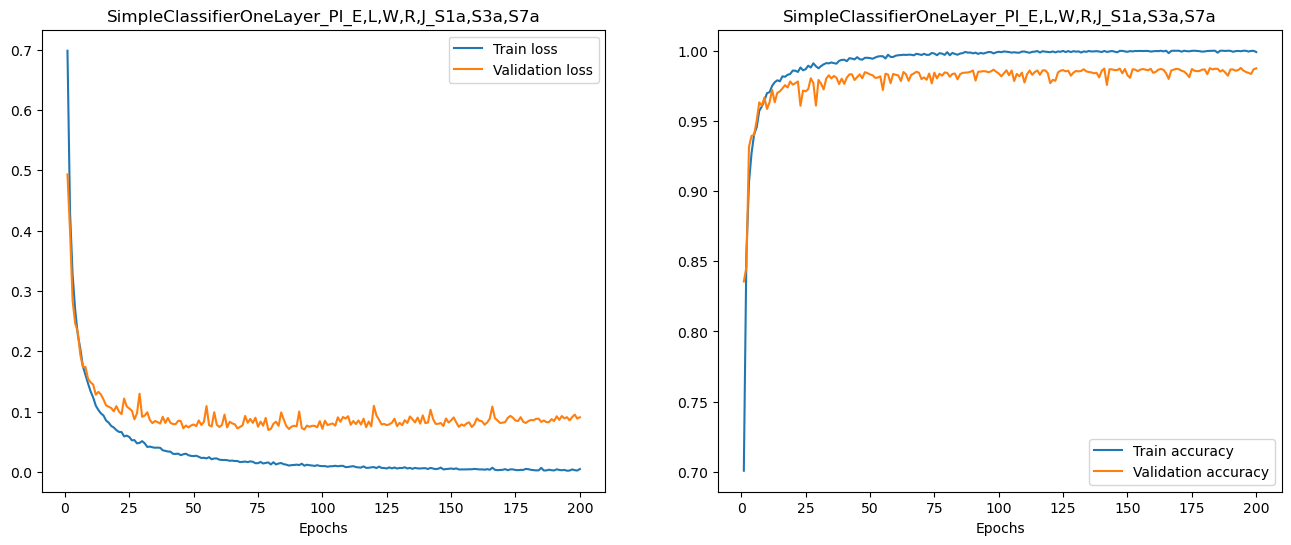

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(np.arange(1, epochs+1), train_losses_PI, label="Train loss")
ax1.plot(np.arange(1, epochs+1), val_losses_PI, label="Validation loss")
ax1.set_xlabel("Epochs")
ax1.set_title(str(save_name_proj)+'_'+str(subdirs_init))
ax1.legend()
ax2.plot(np.arange(1,epochs+1), train_accs_PI, label="Train accuracy")
ax2.plot(np.arange(1,epochs+1), val_accs_PI, label="Validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_title(str(save_name_proj)+'_'+str(subdirs_init))
ax2.legend()

And again, after the training we proceed testing our trained projection head in the same sets considered (so S1, S3 and S7).

In [ ]:
### TEST ###

dataset_PI_test_class, labels_true_test = create_test_set(dir_init=dir_init, subdirs_init=subdirs_init, activities_init=activities_considered, PI=n_people)
test_feats_PI = prepare_data_features(simclr_model, dataset_PI_test_class, device=device, supervised=True)

labels_considered = np.arange(3)

100%|██████████| 199/199 [00:06<00:00, 31.62it/s]


In [38]:
classifier_model = pi_projection_head

# Load the trained projection head here
path_model = save_dir+'/'+save_name_proj+'.ckpt'
classifier_model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu'), weights_only=True))

<All keys matched successfully>

In [39]:
# test the projection head on the test set:
# start from the input test set, extract the feature representation via the encoder

device = 'cuda' if torch.cuda.is_available() else 'cpu'
classifier_model.to(device)
classifier_model.eval()
batch_size = 64
loss_fn = CrossEntropyLoss()

with torch.no_grad():
    predictions = []
    true = []

    test_loader = DataLoader(test_feats_PI, batch_size=batch_size, shuffle=False, drop_last=False)

    for batch in tqdm(test_loader):
        feats, labels = batch
        feats = feats.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(dim=1)
        preds = classifier_model(feats)
        predictions.append(preds)
        true.append(labels)

    predictions = torch.cat(predictions, axis=0) # concatenate the predictions for all batches
    true = torch.cat(true, axis=0)
    print("shape of the predicted labels list:", predictions.shape)
    print("shape of the true labels:", true.shape)
    test_loss = loss_fn(predictions, true)
    true = true.detach().cpu()
    labels_pred_list_test = torch.softmax(predictions, dim=1).detach().cpu()
    labels_pred_test = labels_pred_list_test.argmax(dim=1) # restituisce l'indice del valore maggiore
    test_acc = (labels_pred_test == true).float().mean()
    conf_matrix = confusion_matrix(true, labels_pred_test)
    print(f"loss: {test_loss}, accuracy: {test_acc}")

100%|██████████| 100/100 [00:00<00:00, 598.94it/s]

shape of the predicted labels list: torch.Size([6352, 3])
shape of the true labels: torch.Size([6352])
loss: 0.05580661818385124, accuracy: 0.982997477054596


Also in this case, during the test phase we consider the same merging mentioned before regarding the predictions of the various antennas.

c:\Users\feder\NNDL-HAR-project\utils_traintest.py:463: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(name_fig)
c:\Users\feder\anaconda3\envs\nnml\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


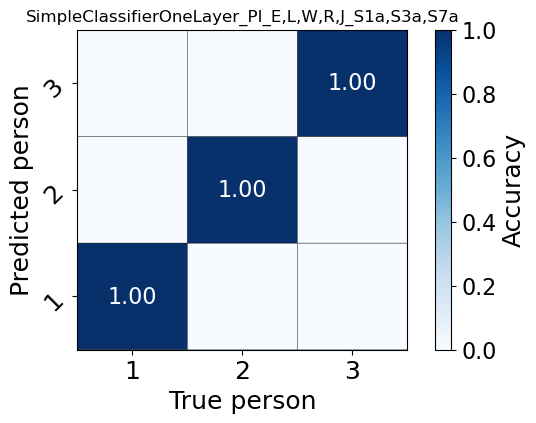

In [40]:
labels_pred_max_merged = merge_predictions(labels_true_test, labels_pred_list_test, labels_pred_test)
conf_matrix_max_merged = confusion_matrix(labels_true_test, labels_pred_max_merged, labels=labels_considered)
people = np.array(['1','2','3'])
plt_confusion_matrix(people.shape[0], conf_matrix_max_merged, lables=people, title=str(save_name_proj)+'_'+str(subdirs_init), save_dir=save_dir, save_name=save_name_proj, PI=True)

### Step 3

Now, regarding HAR, the only thing left is the test of our projection head over the remaining sets, in order to see how well it can generalize over unseen situations (person, environment or day). \
In teh following cell, we define through `subdirs_init` the sets' folders in which we want to perform the test.

In [183]:
dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S7a' #Subdirs for testing our model

From now on, the procedure is the same as before, in which the only (little) difference is just in the notation used.

In [ ]:
dataset_csi_complete, labels_true_test_complete = create_final_test_set(dir_init, subdirs_init, activities_init=activities_considered)
test_feats = prepare_data_features(simclr_model, dataset_csi_complete, device=device, supervised=True)

labels_considered = np.arange(7)

100%|██████████| 516/516 [00:13<00:00, 38.70it/s]


In [185]:
# define a classifier object
classifier_model = har_projection_head
save_name_proj = har_projection_head.name+'_HAR'+'_'+activities_considered
# Load the trained projection head here
path_model = save_dir+'/'+save_name_proj+'.ckpt'
classifier_model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu'), weights_only=True))

<All keys matched successfully>

In [186]:
# test the projection head on the test set:
# start from the input test set, extract the feature representation via the encoder

device = 'cuda' if torch.cuda.is_available() else 'cpu'
classifier_model.to(device)
classifier_model.eval()
batch_size = 64
loss_fn = CrossEntropyLoss()

with torch.no_grad():
    predictions = []
    true = []

    test_loader = DataLoader(test_feats, batch_size=batch_size, shuffle=False, drop_last=False)

    for batch in tqdm(test_loader):
        feats, labels = batch
        feats = feats.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(dim=1)
        preds = classifier_model(feats)
        predictions.append(preds)
        true.append(labels)

    predictions = torch.cat(predictions, axis=0) # concatenate the predictions for all batches
    true = torch.cat(true, axis=0)
    print("shape of the predicted labels list:", predictions.shape)
    print("shape of the true labels:", true.shape)
    test_loss = loss_fn(predictions, true)
    true = true.detach().cpu()
    labels_pred_list_test = torch.softmax(predictions, dim=1).detach().cpu()
    labels_pred_test = labels_pred_list_test.argmax(dim=1) # restituisce l'indice del valore maggiore
    test_acc = (labels_pred_test == true).float().mean()
    conf_matrix = confusion_matrix(true, labels_pred_test)
    print(f"loss: {test_loss}, accuracy: {test_acc}")

100%|██████████| 258/258 [00:00<00:00, 2088.85it/s]

shape of the predicted labels list: torch.Size([16500, 7])
shape of the true labels: torch.Size([16500])
loss: 8.383810043334961, accuracy: 0.6198182106018066


c:\Users\feder\NNDL-HAR-project\utils_traintest.py:463: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(name_fig)
c:\Users\feder\anaconda3\envs\nnml\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


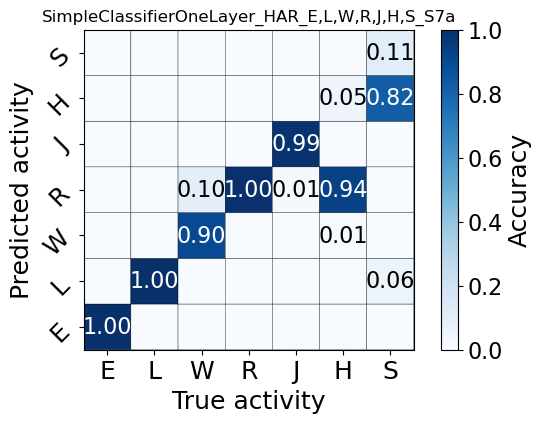

In [187]:
### Merge the predictions from the various antennas ###

labels_pred_max_merged = merge_predictions(labels_true_test_complete, labels_pred_list_test, labels_pred_test)
conf_matrix_max_merged = confusion_matrix(labels_true_test_complete, labels_pred_max_merged, labels=labels_considered)
activities = np.array(['E','L','W','R','J','H','S'])
plt_confusion_matrix(activities.shape[0], conf_matrix_max_merged, lables=activities, title=str(save_name_proj)+'_'+str(subdirs_init), save_dir=save_dir, save_name=save_name_proj)